<a href="https://colab.research.google.com/github/Jathurshan0330/Cine-Cardiac-MRI-Motion-Artefact-Reduction/blob/master/Cine_Cardiac_MRI_Motion_Artifact_Reduction_Using_a_Recurrent_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Get Requirements

In [1]:
!git clone https://github.com/Jathurshan0330/Cine-Cardiac-MRI-Motion-Artefact-Reduction.git

fatal: destination path 'Cine-Cardiac-MRI-Motion-Artefact-Reduction' already exists and is not an empty directory.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from IPython.display import clear_output

In [4]:
!pip install medpy
clear_output()

In [5]:
%cd /content/Cine-Cardiac-MRI-Motion-Artefact-Reduction
import torch
import os
from glob import glob
import time
import re
import argparse
import nibabel as nib
import pandas as pd
from medpy.metric.binary import hd, dc
import numpy as np
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torch
import torch.nn as nn
sns.set_style('darkgrid')
from seaborn.matrix import clustermap
import h5py
from matplotlib.patches import Rectangle
from torch.utils.data import Dataset
from torch.utils import data
from torchvision import transforms, datasets
from torchvision.transforms.transforms import ToTensor
from torchvision import models
from torch import autograd
from matplotlib.animation import FuncAnimation
from IPython import display

from utils.metrics_acdc import load_nii
from datasets.cine_dataset import read_h5py

/content/Cine-Cardiac-MRI-Motion-Artefact-Reduction


#Load and Visualize Data

In [ ]:
img_data_4d, affine_4d, header_4d = load_nii("/content/drive/MyDrive/Cine Cardiac/training/patient021/patient021_4d.nii.gz")
print(img_data_4d.shape, affine_4d.shape)

In [ ]:
def interactive_gif(img, cmap = 'jet'):
  
  def Animate(slice):
    Figure = plt.figure() 
    # creating a plot
    # imgs_plotted = plt.imshow(img[:,:,0,slice], cmap = 'gray') 
    imgs_plotted = plt.imshow(img[:,:,slice,0], cmap = 'gray') 
    plt.axis("off")

    def AnimationFunction(frame):
    
        # setting y according to frame
        # number and + x. It's logic
        # y = img[:,:,frame,slice]
        y = img[:,:,slice,frame]
    
        # line is set with new values of x and y
        imgs_plotted.set_data(y)

    # anim_created = FuncAnimation(Figure, AnimationFunction, frames=img.shape[2]-1, interval=200)
    anim_created = FuncAnimation(Figure, AnimationFunction, frames=img.shape[-1]-1, interval=100)

    video = anim_created.to_html5_video()
    html = display.HTML(video)
    display.display(html)
  
  # good practice to close the plt object.
    plt.close()

  # select_slice = IntSlider(min=0, max=img.shape[-1]-1, description='Select Phase', continuous_update=True)
  select_slice = IntSlider(min=0, max=img.shape[2]-1, description='Select slice', continuous_update=True)

  # select_phase = IntSlider(min=0, max=frame.shape[3]-1, description='Select Phase', continuous_update=True)

  return interactive(Animate, slice=select_slice)#, phase = select_phase)
interactive_gif(img_data_4d, cmap = 'gray')

# Data Analysis

In [ ]:
data_list = glob("/content/drive/MyDrive/Cine Cardiac/training/patient*/patient*_4d.nii.gz")
print(data_list)
phase_list = []
slice_list = []
ignore = ["/content/drive/MyDrive/Cine Cardiac/training/patient009/patient009_4d.nii.gz",]

for i in data_list:
  if i in ignore:
    phase_list.append(0)
    slice_list.append(0)
    continue
  img_data_4d, affine_4d, header_4d = load_nii(i)
  phase_list.append(img_data_4d.shape[-1])
  slice_list.append(img_data_4d.shape[-2])


print(phase_list)
print(slice_list)


In [ ]:
#select scans with 30 phase
select_list = []
for i in range (len(phase_list)):
  if phase_list[i] == 30:
    select_list.append(data_list[i])
print(select_list)
print(len(select_list))

In [ ]:
## Separate into train and val
train_list = select_list[:-7]
val_list = select_list[-7:]
print(len(train_list), len(val_list))

### Create Training Data

In [ ]:
#Create Train Data
img_no = 36
index =  [110,120] #26 [60,130] #22 [80,160]  #18[80,60]  #11, 19, 24 [80,140]    #10 [80,120]   
#7,20,21,23, 27 [90,130]   #3,6,17,25,28 [120,100]     #0-2, 4-5, 8- 10, 12-16, [100,130] 
print(train_list[img_no])
img_data_4d, affine_4d, header_4d = load_nii(train_list[img_no])
print(img_data_4d.shape)
save_path = "/content/drive/MyDrive/Cine Cardiac/train_data/"

for slice_no in range(img_data_4d.shape[-2]): 
  img_frames = img_data_4d[index[0]-50:index[0]+50,index[1]-50:index[1]+50,slice_no,:]
  print(img_frames.shape,img_frames.min(),img_frames.max())

  
  plt.figure()
  plt.imshow(img_data_4d[:,:,slice_no,14],cmap='gray')
  # plt.gca().add_patch(Rectangle((index[0]-50,index[1]-50),100,100,linewidth=1,edgecolor='r',facecolor='none'))
  plt.axis('off')
  plt.show()

  plt.figure()
  plt.imshow(img_frames[:,:,14],cmap='gray')
  plt.axis('off')
  plt.show()

  hf = h5py.File(save_path+f'train_{train_list[img_no][-13:-10]}_slice_{slice_no}.h5', 'w')
  hf.create_dataset('train', data = img_frames)
  hf.close()


In [ ]:
h5_file = "/content/drive/MyDrive/Cine Cardiac/train_data/train_076_slice_1.h5"

img_test = read_h5py(h5_file)
print(len(img_test))
img_test = np.reshape(img_test,(100,100,1,30))
interactive_gif(img_test, cmap = 'gray')

### Create Validation Data

In [ ]:
#Create Val Data

img_no = 6
index =  [100,140] #26 [60,130] #22 [80,160]  #18[80,60]  #11, 19, 24 [80,140]    #10 [80,120]   
#7,20,21,23, 27 [90,130]   #3,6,17,25,28 [120,100]     #0-2, 4-5, 8- 10, 12-16, [100,130] 
print(val_list[img_no])
img_data_4d, affine_4d, header_4d = load_nii(val_list[img_no])
print(img_data_4d.shape)
save_path = "/content/drive/MyDrive/Cine Cardiac/val_data/"

for slice_no in range(img_data_4d.shape[-2]): 
  img_frames = img_data_4d[index[0]-50:index[0]+50,index[1]-50:index[1]+50,slice_no,:]
  print(img_frames.shape,img_frames.min(),img_frames.max())

  
  plt.figure()
  plt.imshow(img_data_4d[:,:,slice_no,14],cmap='gray')
  # plt.gca().add_patch(Rectangle((index[0]-50,index[1]-50),100,100,linewidth=1,edgecolor='r',facecolor='none'))
  plt.axis('off')
  plt.show()

  plt.figure()
  plt.imshow(img_frames[:,:,14],cmap='gray')
  plt.axis('off')
  plt.show()

  hf = h5py.File(save_path+f'val_{val_list[img_no][-13:-10]}_slice_{slice_no}.h5', 'w')
  hf.create_dataset('val', data = img_frames)
  hf.close()


In [ ]:
h5_file = "/content/drive/MyDrive/Cine Cardiac/val_data/val_097_slice_1.h5"

img_test = read_h5py(h5_file)
img_test = np.reshape(img_test,(100,100,1,30))
interactive_gif(img_test, cmap = 'gray')

# Load Dataset Class

#### ACDC motion blurring


In [ ]:
# img_data_4d, _,_ = load_nii("/content/drive/MyDrive/Cine Cardiac/training/patient021/patient021_4d.nii.gz")
# img = img_data_4d[:,:240,0,:]
# # img = read_h5py(val_data[14])
# img = (img - np.min(img))/(np.max(img) - np.min(img))
# print(img.shape, np.max(img))
# N = 7
# start_ind = N
# end_ind = 30-N
# motion_artefact_added = []
# eps = 10e-9

# def calculate_2dft(input):
#     ft = np.fft.fft2(input)
#     return np.fft.fftshift(ft)
# def calculate_2dift(input):
#     ift = np.fft.ifftshift(input)
#     ift = np.fft.ifft2(ift)
#     return ift.real

# fft_2d = calculate_2dft(img[:,:,7])
# plt.figure()
# plt.imshow(np.log(np.abs(fft_2d)),cmap = 'gray')
# plt.colorbar()


# ifft_img = calculate_2dift(fft_2d)
# fig, ax = plt.subplots(1,3, figsize=(10,10))
# ax[0].imshow(np.log(np.abs(fft_2d)),cmap = 'gray'), ax[0].axis('off')
# ax[1].imshow(ifft_img,cmap = 'gray'), ax[1].axis('off')
# ax[2].imshow(img[:,:,7],cmap = 'gray'), ax[2].axis('off')
# plt.show()



# for i in range(start_ind,end_ind):
#   fft_mixed = calculate_2dft(img[:,:,i])#np.zeros(img[:,:,i].shape)
#   fig, ax = plt.subplots(3,5, figsize=(20,10))
#   for j in range(0,2*N+1): 
#     fft_2d = calculate_2dft(img[:,:,(i+j)-N])
#     fft_mixed[:,j*16:(j+1)*16] = fft_2d[:,j*16:(j+1)*16]

#     # if j<N:
#     #     fft_mixed[:,j*14:(j+1)*14] = fft_2d[:,j*14:(j+1)*14]
#     # elif j == N:
#     #   fft_mixed[:,j*14: 240-N*14] = fft_2d[:,j*14: 240-N*14]
#     # elif j>N:
#     #   fft_mixed[:,142+(j-N-1)*14: 142+(j-N)*14] = fft_2d[:,142+(j-N-1)*14: 142+(j-N)*14]

#     # print(fft_2d.shape)
#     ax[j//5][j%5].imshow(img[:,:,(i+j)-N], cmap='gray'), ax[j//5][j%5].set_title(f'FFt 2D Frame {j}'),ax[j//5][j%5].axis('off')
#   # plt.show()

#   plt.figure()
#   plt.imshow(np.log(np.abs(fft_mixed)+eps),cmap = 'gray',vmax = 8, vmin = -6)
#   plt.axis('off')
#   plt.colorbar()
#   plt.show()

#   # fft_mixed[0:25,:] = 0
#   # fft_mixed[-25:,:] = 0
#   # fft_mixed[:,0:25] = 0
#   # fft_mixed[:,-25:] = 0

#   plt.figure()
#   plt.imshow(np.log(np.abs(fft_mixed)+eps),cmap = 'gray',vmax = 8, vmin = -6)
#   plt.axis('off')
#   plt.colorbar()
#   plt.show()

#   ma_img = calculate_2dift(fft_mixed)

#   fig, ax = plt.subplots(1,2, figsize=(10,10))
#   ax[0].imshow(img[:,:,i],cmap = 'gray'), ax[0].axis('off')
#   ax[1].imshow(ma_img,cmap = 'gray'), ax[1].axis('off')
#   plt.show()

#   motion_artefact_added.append(ma_img)
#   break

# motion_artefact_added = np.reshape(np.array(motion_artefact_added),(1,end_ind - start_ind,100,100))


# interactive_gif_data(motion_artefact_added, cmap = 'gray')



# # fig, ax = plt.subplots(3,10, figsize=(30,10))
# # for i in range(30):
# #   ax[i//10][i%10].imshow(img[:,:,i], cmap='gray'), ax[i//10][i%10].set_title(f'Frame {i}'),ax[i//10][i%10].axis('off')


## Dataset

In [6]:
def calculate_2dft(input):
    ft = np.fft.fft2(input)
    return np.fft.fftshift(ft)
def calculate_2dift(input):
    ift = np.fft.ifftshift(input)
    ift = np.fft.ifft2(ift)
    return ift.real

def add_motion_artefacts(img):
  N = 7
  start_ind = N
  end_ind = 30-N
  motion_artefact_added = []
  eps = 10e-11

  for i in range(start_ind,end_ind):
    fft_mixed = calculate_2dft(img[:,:,i])

    # K-space mixing
    for j in range(0,2*N+1): 
      fft_2d = calculate_2dft(img[:,:,(i+j)-N])
      if j<N:
        fft_mixed[:,j*6:(j+1)*6] = fft_2d[:,j*6:(j+1)*6]
      elif j == N:
        fft_mixed[:,j*6: 58] = fft_2d[:,j*6:58]
      elif j>N:
        fft_mixed[:,58+(j-N-1)*6: 58+(j-N)*6] = fft_2d[:,58+(j-N-1)*6: 58+(j-N)*6]

    # Zero Padding
    fft_mixed[0:25,:] = 0
    fft_mixed[-25:,:] = 0
    fft_mixed[:,0:25] = 0
    fft_mixed[:,-25:] = 0

    ma_img = calculate_2dift(fft_mixed)
    motion_artefact_added.append(ma_img)

  motion_artefact_added = np.array(motion_artefact_added)
  return motion_artefact_added

In [7]:
class CineCardiac(Dataset):
    def __init__(self, data_list, device,data_type = None,  transform=None, target_transform=None):
        
        first = True
        for base in data_list:
          if first:
            self.img_data = np.reshape(read_h5py(base),(1,100,100,30))
            first = False
          else:
            self.img_data = np.concatenate((self.img_data,np.reshape(read_h5py(base),(1,100,100,30))),axis = 0)

        print(self.img_data.shape)    
        self.device = device
        self.transform = transform
        self.target_transform = target_transform


    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, idx):
      gt = (self.img_data[idx] - np.min(self.img_data[idx]))/(np.max(self.img_data[idx]) - np.min(self.img_data[idx])) #Normalizing to [0,1]
      img = add_motion_artefacts(gt)
      img = np.moveaxis(img,0,-1)
      gt = gt[:,:,7:23]
      img_inv = np.zeros((100,100,16))
      for i in range(16):
          img_inv[:,:,i] = img[:,:,15-i]
      img = img[:,:,9-3:9+4]
      img_inv = img_inv[:,:,9-3:9+4]
      gt = gt[:,:,9-3:9+4]
      # print(img.shape,gt.shape)
      if self.transform:
          img = self.transform(img).to(self.device)  
          img_inv = self.transform(img_inv).to(self.device)  
          gt  = self.transform(gt).to(self.device)  
      return img, img_inv, gt

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
#Cine Cardiac MRI Dataset
train_data = glob("/content/drive/MyDrive/Cine Cardiac/train_data/train_*_slice_*.h5")
val_data = glob("/content/drive/MyDrive/Cine Cardiac/val_data/val_*_slice_*.h5")
print(train_data)
print(val_data)


cine_train = CineCardiac(data_list = train_data, 
                          device = device, 
                          transform=transforms.Compose([
                          transforms.ToTensor(),
                          ])) 

cine_val = CineCardiac(data_list = val_data, 
                          device = device, data_type = 'Val', 
                          transform=transforms.Compose([
                          transforms.ToTensor(),
                          ])) 
clear_output()

In [10]:
# Data loaders
train_data_loader = data.DataLoader(cine_train, batch_size = 1, shuffle = True)
val_data_loader = data.DataLoader(cine_val, batch_size = 1, shuffle = False)

In [11]:
def interactive_gif_data(img, cmap = 'gray'):
  
  def Animate(slice):
    Figure = plt.figure() 
    # creating a plot
    imgs_plotted = plt.imshow(img[slice,0,:,:], cmap = 'gray') 
    plt.axis("off")

    def AnimationFunction(frame):
        y = img[slice,frame,:,:]
    
        # line is set with new values of x and y
        imgs_plotted.set_data(y)

    anim_created = FuncAnimation(Figure, AnimationFunction, frames=img.shape[1]-1, interval=100)

    video = anim_created.to_html5_video()
    html = display.HTML(video)
    display.display(html)
    # plt.show()
  # good practice to close the plt object.
    plt.close()

  select_slice = IntSlider(min=0, max=img.shape[0]-1, description='Select slice', continuous_update=True)


  return interactive(Animate, slice=select_slice)


torch.Size([1, 7, 100, 100]) torch.Size([1, 7, 100, 100]) torch.Size([1, 7, 100, 100])


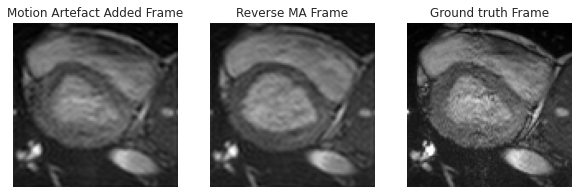

interactive(children=(IntSlider(value=0, description='Select slice', max=0), Output()), _dom_classes=('widget-…

In [12]:
img,img_inv, label   = next(iter(val_data_loader))
print(img.shape,img_inv.shape, label.shape)

ind = 0
fig, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(img[ind,0,:,:].cpu(), cmap='gray'), ax[0].set_title('Motion Artefact Added Frame'),ax[0].axis("off")
ax[1].imshow(img_inv[ind,0,:,:].cpu(), cmap='gray'), ax[1].set_title('Reverse MA Frame'),ax[1].axis("off")
ax[2].imshow(label[ind,0,:,:].cpu(), cmap='gray'), ax[2].set_title('Ground truth Frame'),ax[2].axis("off")
plt.show()

interactive_gif_data(img.cpu(), cmap = 'gray')


In [13]:
interactive_gif_data(label.cpu(), cmap = 'gray')

interactive(children=(IntSlider(value=0, description='Select slice', max=0), Output()), _dom_classes=('widget-…

# Recurrent Generative Adversarial Neural Network

In [14]:
class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out,kernel_size,padding = 1, bias = False):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=kernel_size,stride=1,padding=padding,bias=bias),
            nn.ReLU()
        )

    def forward(self,x):
        x = self.conv(x)
        return x

class convtranspose_block(nn.Module):
    def __init__(self,ch_in,ch_out,kernel_size):
        super(convtranspose_block,self).__init__()
        self.convtrans = nn.Sequential(
            nn.ConvTranspose2d(ch_in, ch_out, kernel_size=kernel_size,stride=1,padding=1,bias=False),
            nn.ReLU()
        )

    def forward(self,x):
        x = self.convtrans(x)
        return x


class multi_scale_conv(nn.Module):
  def __init__(self,ch_in,ch_out):
        super(multi_scale_conv,self).__init__()
        self.conv3x3 = conv_block(ch_in = ch_in,ch_out = ch_out, kernel_size = 3, padding=1)
        self.conv5x5 = conv_block(ch_in = ch_in,ch_out = ch_out, kernel_size = 5, padding=2)
        self.conv7x7 = conv_block(ch_in = ch_in,ch_out = ch_out, kernel_size = 7, padding=3)
        self.conv1x1 = conv_block(ch_in = ch_out*3,ch_out = ch_out, kernel_size = 1, padding = 0)

  def forward(self,x):
      x1 = self.conv3x3(x)
      x2 = self.conv5x5(x)
      x3 = self.conv7x7(x)
      comb = torch.cat((x1, x2, x3), 1)
      out = self.conv1x1(comb)
      return out





In [15]:
##ConvLSTMS
class ConvLSTMCell(nn.Module):
  def __init__(self,ch_in,ch_hidden, kernel_size, bias):
    super(ConvLSTMCell,self).__init__()

    self.ch_in = ch_in
    self.ch_hidden = ch_hidden
    self.kernel_size = kernel_size
    self.padding = 1
    self.bias = bias

    self.conv = nn.Conv2d(in_channels = self.ch_in + self.ch_hidden, out_channels = 4*self.ch_hidden,
                          kernel_size = self.kernel_size, padding = self.padding, bias = self.bias)

  def forward(self,x,current_state):
    h_current, c_current = current_state

    x1 = self.conv(torch.cat([x, h_current], dim=1))

    cc_i, cc_f, cc_o, cc_g = torch.split(x1, self.ch_hidden, dim=1)
    i = torch.sigmoid(cc_i)
    f = torch.sigmoid(cc_f)
    o = torch.sigmoid(cc_o)
    g = torch.tanh(cc_g)

    c_next = f * c_current + i * g
    h_next = o * torch.tanh(c_next)

    return h_next, c_next
  
  def init_hidden(self, batch_size, image_size):
    height, width = image_size
    return (torch.zeros(batch_size, self.ch_hidden, height, width, device=self.conv.weight.device),
            torch.zeros(batch_size, self.ch_hidden, height, width, device=self.conv.weight.device))



class ConvLSTM(nn.Module):
  def __init__(self,ch_in,ch_hidden, kernel_size,num_layers, batch_first=False, bias=True, return_all_layers=False):
    super(ConvLSTM,self).__init__()

    kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
    ch_hidden = self._extend_for_multilayer(ch_hidden, num_layers)
    if not len(kernel_size) == len(ch_hidden) == num_layers:
        raise ValueError('Inconsistent list length.')

    self.ch_in = ch_in
    self.ch_hidden = ch_hidden
    self.kernel_size = kernel_size
    self.num_layers = num_layers
    self.batch_first = batch_first
    self.bias = bias
    self.return_all_layers = return_all_layers

    convlstmcell_list = []
    for i in range(0, self.num_layers):
        cur_input_dim = self.ch_in if i == 0 else self.ch_hidden[i - 1]

        convlstmcell_list.append(ConvLSTMCell(ch_in=cur_input_dim,
                                      ch_hidden=self.ch_hidden[i],
                                      kernel_size=self.kernel_size[i],
                                      bias=self.bias))

    self.convlstmcell_list = nn.ModuleList(convlstmcell_list)

  def forward(self, x, hidden_state=None):
   
    if not self.batch_first:
        # (t, b, c, h, w) -> (b, t, c, h, w)
        x = x.permute(1, 0, 2, 3, 4)

    b, _, _, h, w = x.size()
    # print(x.size())
    # Implement stateful ConvLSTM
    if hidden_state is not None:
        raise NotImplementedError()
    else:
        # Since the init is done in forward. Can send image size here
        hidden_state = self._init_hidden(batch_size=b,
                                          image_size=(h, w))
        

    seq_len = x.size(1)
    cur_layer_input = x

    for layer_idx in range(self.num_layers):

        h, c = hidden_state[layer_idx]
        # print(h,c)
        output_inner = []
        for t in range(seq_len):
            h, c = self.convlstmcell_list[layer_idx](x=cur_layer_input[:, t, :, :, :],
                                              current_state=[h, c])
            output_inner.append(h)

        layer_output = torch.stack(output_inner, dim=1)
        cur_layer_input = layer_output

    return layer_output

  def _init_hidden(self, batch_size, image_size):
      init_states = []
      for i in range(self.num_layers):
          init_states.append(self.convlstmcell_list[i].init_hidden(batch_size, image_size))
      return init_states

  @staticmethod
  def _extend_for_multilayer(param, num_layers):
      if not isinstance(param, list):
          param = [param] * num_layers
      return param



class ConvLSTM_block(nn.Module):
  def __init__(self):
        super(ConvLSTM_block,self).__init__()
        self.convlstm1 = ConvLSTM(ch_in = 1, ch_hidden = 32, kernel_size = (3,3), num_layers = 1, batch_first = True, bias = True, return_all_layers = False)
        self.relu1     = nn.ReLU()

        self.convlstm2 = ConvLSTM(ch_in = 32, ch_hidden = 64, kernel_size = (3,3), num_layers = 1, batch_first = True, bias = True, return_all_layers = False)
        self.relu2     = nn.ReLU()

        self.convlstm3 = ConvLSTM(ch_in = 64, ch_hidden = 128, kernel_size = (3,3), num_layers = 1, batch_first = True, bias = True, return_all_layers = False)
        self.relu3     = nn.ReLU()


  def forward(self,x):
      x = x.view(x.shape[0],x.shape[1],1,x.shape[2],x.shape[3])

      out1 = self.convlstm1(x)
      out1 = self.relu1(out1)

      out2 = self.convlstm2(out1)
      out2 = self.relu2(out2)

      out3 = self.convlstm3(out2)
      out3 = self.relu3(out3)
      return out1, out2, out3


In [16]:
class encoder(nn.Module):
    def __init__(self):
        super(encoder,self).__init__()

        # self.convlstm_forward = ConvLSTM_block()
        # self.convlstm_backward = ConvLSTM_block()

        self.multi_conv1 = multi_scale_conv(1,32)
        self.conv1 = conv_block(ch_in = 32*3 ,ch_out = 32, kernel_size = 3, padding=1)

        self.multi_conv2 = multi_scale_conv(32,64)
        self.conv2 = conv_block(ch_in = 64*3 ,ch_out = 64, kernel_size = 3, padding=1)

        self.multi_conv3 = multi_scale_conv(64,128)
        self.conv3 = conv_block(ch_in = 128*3 ,ch_out = 128, kernel_size = 3, padding=1)

        self.multi_conv4 = multi_scale_conv(128,256)

    def forward(self,x, f1,f2,f3,b1,b2,b3):

        # f1,f2,f3 = self.convlstm_forward(x) 
        # b1,b2,b3 = self.convlstm_backward(x_inv)
        feature_maps = []

        out1 = self.multi_conv1(x)
        out1 = torch.cat((out1, f1, b1), 1)
        out1 = self.conv1(out1)

        out2 = self.multi_conv2(out1)
        out2 = torch.cat((out2, f2, b2), 1)
        out2 = self.conv2(out2)

        out3 = self.multi_conv3(out2)
        out3 = torch.cat((out3, f3, b3), 1)
        out3 = self.conv3(out3)
        
        out4 = self.multi_conv4(out3)
        return out1,out2,out3,out4



class decoder(nn.Module):
    def __init__(self):
        super(decoder,self).__init__()

        self.convtrans1 = convtranspose_block(ch_in = 256, ch_out = 128, kernel_size = 3)

        self.convtrans2 = convtranspose_block(ch_in = 128*2, ch_out = 128, kernel_size = 3)
        self.convtrans3 = convtranspose_block(ch_in = 128, ch_out = 64, kernel_size = 3)

        self.convtrans4 = convtranspose_block(ch_in = 64*2, ch_out = 64, kernel_size = 3)
        self.convtrans5 = convtranspose_block(ch_in = 64, ch_out = 32, kernel_size = 3)

        self.convtrans6 = convtranspose_block(ch_in = 32*2, ch_out = 32, kernel_size = 3)
        self.convtrans7 = convtranspose_block(ch_in = 32, ch_out = 1, kernel_size = 3)

    def forward(self,in1,in2,in3,in4):
        out1 = self.convtrans1(in4)

        out2 = torch.cat((out1, in3), 1)
        out2 = self.convtrans2(out2)
        out2 = self.convtrans3(out2)
        
        out3 = torch.cat((out2, in2), 1)
        out3 = self.convtrans4(out3)
        out3 = self.convtrans5(out3)

        out4 = torch.cat((out3, in1), 1)
        out4 = self.convtrans6(out4)
        out4 = self.convtrans7(out4)

        return out4


class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()

        self.encoder = encoder()
        self.decoder = decoder()

    def forward(self,x,f1,f2,f3,b1,b2,b3):
        out1,out2,out3,out4 = self.encoder(x,f1,f2,f3,b1,b2,b3)
        out = self.decoder(out1,out2,out3,out4)

        return out

In [17]:
#Discriminator

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1_1 = conv_block(ch_in = 1 ,ch_out = 64, kernel_size = 3, padding=1, bias = True)
        self.conv1_2 = conv_block(ch_in = 64 ,ch_out = 64, kernel_size = 3, padding=1, bias = True)
        self.maxpool1 = nn.MaxPool2d(2,2)

        self.conv2_1 = conv_block(ch_in = 64 ,ch_out = 128, kernel_size = 3, padding=1, bias = True)
        self.conv2_2 = conv_block(ch_in = 128 ,ch_out = 128, kernel_size = 3, padding=1, bias = True)
        self.maxpool2 = nn.MaxPool2d(2,2)

        self.conv3_1 = conv_block(ch_in = 128,ch_out = 256, kernel_size = 3, padding=1, bias = True)
        self.conv3_2 = conv_block(ch_in = 256 ,ch_out = 256, kernel_size = 3, padding=1, bias = True)
        self.maxpool3 = nn.MaxPool2d(2,2)

        self.fc1   = nn.Linear(12*12*256, 1024)
        self.relu1 = nn.ReLU(True)
        self.fc2   = nn.Linear(1024,1)
        self.relu2 = nn.ReLU(True)

    def forward(self, x):
        out1 = self.conv1_1 (x)
        out1 = self.conv1_2 (out1)
        out1 = self.maxpool1(out1)

        out2 = self.conv2_1 (out1)
        out2 = self.conv2_2 (out2)
        out2 = self.maxpool2(out2)

        out3 = self.conv3_1 (out2)
        out3 = self.conv3_2 (out3)
        out3 = self.maxpool3(out3)

        # print(out3.shape)
        out3 = out3.view(-1, 12*12*256)
        out = self.fc1(out3)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        
        return out

In [18]:
# Vgg16 for perception loss
#help https://github.com/pytorch/examples

class Vgg16(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(Vgg16, self).__init__()
        vgg_pretrained_features = models.vgg16(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        # vgg_outputs = namedtuple("VggOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3'])
        # out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3)
        return [h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3]


def gradient_penalty(netD, real, fake):
    c,s,h,w = real.shape
    alpha = torch.rand(c, s, h, w)
    alpha = alpha.expand(real.size())
    alpha = alpha.to(device) if torch.cuda.is_available() else alpha

    interpolates = alpha * real + ((1 - alpha) * fake)

    interpolates = interpolates.to(device)
    interpolates = autograd.Variable(interpolates, requires_grad=True)

    disc_interpolates = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).to(device) if torch.cuda.is_available() else torch.ones(
                                  disc_interpolates.size()),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# Model Training

In [19]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count if self.count != 0 else 0

In [20]:
convlstm_forward = ConvLSTM_block().to(device)
convlstm_backward = ConvLSTM_block().to(device)
gen = Generator().to(device)
disc = Discriminator().to(device)
vgg =  Vgg16().to(device)

adv_loss = nn.BCELoss()
mse_loss = nn.MSELoss()

lr = 1e-4
beta_1 = 0.5 
beta_2 = 0.999
n_epochs = 50

for_convlstm_optimizer =  torch.optim.Adam(convlstm_forward.parameters(), lr=lr, betas=(beta_1, beta_2))
back_convlstm_optimizer =  torch.optim.Adam(convlstm_backward.parameters(), lr=lr, betas=(beta_1, beta_2))
gen_optimizer =  torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc_optimizer =  torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

img,img_inv, label   = next(iter(val_data_loader))
print(img.shape,img_inv.shape, label.shape)
# img = torch.reshape(img,(img.shape[0],img.shape[1],1,img.shape[2],img.shape[3]))
# img_inv = torch.reshape(img_inv,(img.shape[0],7,1,100,100))
print(img.shape,img_inv.shape, label.shape)


sides = []
f1,f2,f3 = convlstm_forward(img.float()) 
b1,b2,b3 = convlstm_backward(img_inv.float())

print(f1.shape,f2.shape,f3.shape)
print(b1.shape,b2.shape,b3.shape)


for i in range (7):
  out_img = gen(img[:,i,:,:].view(img.shape[0],1,100,100).float(),f1[:,i,:,:,:], f2[:,i,:,:,:], f3[:,i,:,:,:],
                b1[:,i,:,:,:], b2[:,i,:,:,:], b3[:,i,:,:,:])
  pred_disc = disc(out_img)
  sides.append(out_img)
  print(out_img.shape, pred_disc.shape)


print(len(sides),sides[0].shape)

torch.Size([1, 7, 100, 100]) torch.Size([1, 7, 100, 100]) torch.Size([1, 7, 100, 100])
torch.Size([1, 7, 100, 100]) torch.Size([1, 7, 100, 100]) torch.Size([1, 7, 100, 100])
torch.Size([1, 7, 32, 100, 100]) torch.Size([1, 7, 64, 100, 100]) torch.Size([1, 7, 128, 100, 100])
torch.Size([1, 7, 32, 100, 100]) torch.Size([1, 7, 64, 100, 100]) torch.Size([1, 7, 128, 100, 100])
torch.Size([1, 1, 100, 100]) torch.Size([1, 1])
torch.Size([1, 1, 100, 100]) torch.Size([1, 1])
torch.Size([1, 1, 100, 100]) torch.Size([1, 1])
torch.Size([1, 1, 100, 100]) torch.Size([1, 1])
torch.Size([1, 1, 100, 100]) torch.Size([1, 1])
torch.Size([1, 1, 100, 100]) torch.Size([1, 1])
torch.Size([1, 1, 100, 100]) torch.Size([1, 1])
7 torch.Size([1, 1, 100, 100])


In [24]:
#Initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

def img_net_normalize(x):
    return torch.cat(((x-0.485)/0.229, (x-0.456)/0.224, (x-0.406)/0.225), 1)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

## Training 

### Neptune

In [22]:
!pip install neptune-client
clear_output()

In [ ]:
import neptune.new as neptune

# run = neptune.init(
#     project="jathurshan0330/Cine-Cardiac",
#     api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJmYmRmNjE0Zi0xMDRkLTRlNzUtYmIxNi03NzM2ODBlZDc5NTMifQ==",
# )  # your credentials


In [ ]:
parameters = {
    "Experiment": "Recurrent Generative Adversarial Based Network",
    'Batch Size': 1,
    'Loss': "Adversarial loss + Perception Loss",
    'Optimizer' : "Adam",
    'Learning Rate': lr,
    'Beta 1': beta_1,
    'Beta 2': beta_2,
    'n_epochs': n_epochs
}
run['model/parameters'] = parameters
run['model/ConvLSTM'] = convlstm_forward
run['model/Generator'] = gen
run['model/Discriminator'] = disc


### Train

In [ ]:
from torchvision.utils import make_grid
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import time

vgg.eval()
num_frames = 7
lambda_percep = 0.1 
save_model_freq = 10
val_best_loss = 10000000
val_best_psnr = 10

for epoch_idx in range(0,n_epochs):
  print(f"Training Epoch : [{epoch_idx+1}/{n_epochs}]===============================================================================")
  convlstm_forward.train()
  convlstm_backward.train()
  gen.train()
  disc.train()

  batch_time = AverageMeter()
  data_time = AverageMeter()
  #Total loss
  train_total_gen_losses = AverageMeter()
  train_total_disc_losses = AverageMeter()
  #Adversarial Loss
  train_adv_losses = AverageMeter()
  #Perceptual loss
  train_percep_losses = AverageMeter()
  val_percep_losses = AverageMeter()
  
  PSNR_val = AverageMeter()
  SSIM_val = AverageMeter()
  end = time.time()
  
  for batch_idx, data_input in enumerate(train_data_loader):
    data_time.update(time.time() - end)
    train_img = data_input[0].to(device) 
    inv_train_img = data_input[1].to(device) 
    gt_img = data_input[2].to(device)

    disc_optimizer.zero_grad()
    gen_optimizer.zero_grad()
    for_convlstm_optimizer.zero_grad()
    back_convlstm_optimizer.zero_grad()

    ########### Update Generator ###########
    for p in disc.parameters():
      p.requires_grad = False
    
    
    #ConvLSTMs (Forward and Backward)
    f1_train,f2_train,f3_train = convlstm_forward(train_img.float()) 
    b1_train,b2_train,b3_train = convlstm_backward(inv_train_img.float())

    # gen_frames = []
    adver_loss = 0
    percep_loss = 0
    for k in range (num_frames):
      gen_img = gen(train_img[:,k,:,:].view(train_img.shape[0],1,100,100).float(),f1_train[:,k,:,:,:], f2_train[:,k,:,:,:], f3_train[:,k,:,:,:],
                    b1_train[:,k,:,:,:], b2_train[:,k,:,:,:], b3_train[:,k,:,:,:])
      disc_fake = disc(gen_img)
      
      #Adversarial Loss
      adver_loss += -disc_fake.mean()/num_frames  

      gen_features = vgg(img_net_normalize(gen_img))
      gt_features = vgg(img_net_normalize(gt_img[:,k,:,:,:].view(gt_img.shape[0],1,100,100).float()))
      
      #Perceptual loss
      for f_map in range(4):  
        percep_loss += 0.25 * mse_loss(gen_features[f_map], gt_features[f_map]) / num_frames

      # gen_frames.append(gen_img)
      print(out_img.shape, pred_disc.shape)
    
    #Generator Loss
    gen_loss = adver_loss + lambda_percep*percep_loss
    
    gen_loss.backward()

    # Update Generator
    gen_optimizer.step()
    for_convlstm_optimizer.step()
    back_convlstm_optimizer.step()

    ########### Update Discriminator ###########

    
